In [20]:
import os
import pickle

import mediapipe as mp
import cv2
import matplotlib.pyplot as plt

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:

mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

hands = mp_hands.Hands(static_image_mode=True, min_detection_confidence=0.3)

DATA_DIR = './data'

data = []
labels = []
for dir_ in os.listdir(DATA_DIR):
    for img_path in os.listdir(os.path.join(DATA_DIR, dir_)):
        data_aux = []

        x_ = []
        y_ = []

        img = cv2.imread(os.path.join(DATA_DIR, dir_, img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        results = hands.process(img_rgb)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y

                    x_.append(x)
                    y_.append(y)

                for i in range(len(hand_landmarks.landmark)):
                    x = hand_landmarks.landmark[i].x
                    y = hand_landmarks.landmark[i].y
                    data_aux.append(x - min(x_))
                    data_aux.append(y - min(y_))

            data.append(data_aux)
            labels.append(dir_)

f = open('data.pickle', 'wb')
pickle.dump({'data': data, 'labels': labels}, f)
f.close()


d:\SystemInstalls\Python\Python310\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [5]:
# Load the data
data_dict = pickle.load(open('./data.pickle', 'rb'))

In [6]:
# Check the lengths of each data point
data_lengths = [len(data_point) for data_point in data_dict['data']]
unique_lengths = set(data_lengths)
print(f"Unique lengths of data points: {unique_lengths}")

# Find the maximum length
max_length = max(unique_lengths)

# Pad the data points to the maximum length
data_padded = []
for data_point in data_dict['data']:
    if len(data_point) < max_length:
        # Pad with zeros if the data point is shorter than the maximum length
        padded_data_point = np.pad(data_point, (0, max_length - len(data_point)), 'constant')
    else:
        # If the data point is already the maximum length, no padding is needed
        padded_data_point = data_point
    data_padded.append(padded_data_point)

# Convert the padded data and labels to numpy arrays
data = np.asarray(data_padded)
labels = np.asarray(data_dict['labels'])

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels)

Unique lengths of data points: {42, 84}


In [12]:
# Train the model with cross-validation
model = RandomForestClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cv_scores = cross_val_score(model, x_train, y_train, cv=cv)

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores)}")

d:\SystemInstalls\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [0.98901201 0.98621846 0.98640343 0.98975601 0.98845223]
Mean cross-validation score: 0.9879684255826339


In [15]:
# Train the model on the full training data
model.fit(x_train, y_train)

RandomForestClassifier()

99.11% of samples were classified correctly!

Classification Report:
              precision    recall  f1-score   support

           A       0.99      1.00      0.99       462
           B       0.99      1.00      1.00       452
           C       1.00      1.00      1.00       431
           D       1.00      1.00      1.00       519
           E       0.99      0.99      0.99       475
           F       0.99      1.00      0.99       589
           G       1.00      1.00      1.00       521
           H       1.00      1.00      1.00       501
           I       0.99      0.99      0.99       501
           J       0.99      0.99      0.99       535
           K       1.00      1.00      1.00       552
           L       1.00      1.00      1.00       522
           M       0.93      0.98      0.96       378
           N       0.98      0.92      0.95       307
           O       1.00      0.99      0.99       475
           P       1.00      0.99      0.99       425
           Q

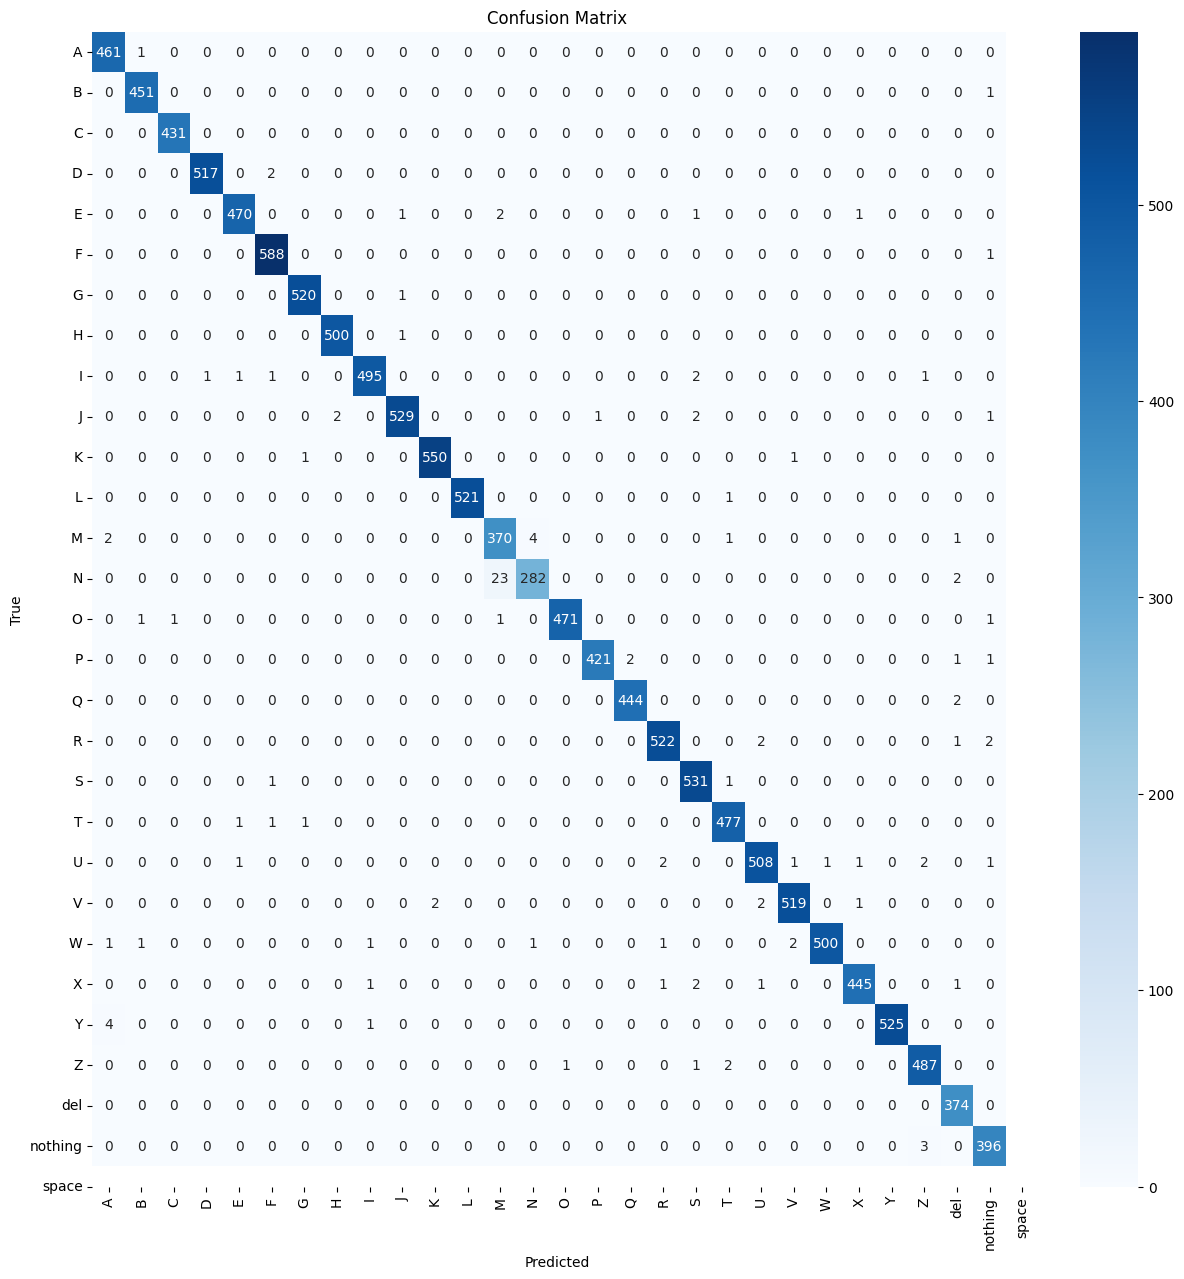

In [22]:
# Predict on the test set
y_predict = model.predict(x_test)

# Calculate accuracy
score = accuracy_score(y_predict, y_test)
print(f'{score * 100:.2f}% of samples were classified correctly!')

# Calculate additional metrics
print("\nClassification Report:")
print(classification_report(y_test, y_predict))

cm = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the trained model
with open('model.p', 'wb') as f:
    pickle.dump({'model': model}, f)